# Fall 2024 Data Science Track: Week 5 - Unsupervised Learning

## Packages, Packages, Packages!

Import *all* the things here! You need: `matplotlib`, `networkx`, `numpy`, and `pandas`―and also `ast.literal_eval` to correctly deserialize two columns in the `rules.tsv.xz` file.

If you got more stuff you want to use, add them here too. 🙂

In [42]:
# Import stuff.
import matplotlib as mpl
import networkx as nx
import numpy as np
import pandas as pd
from ast import literal_eval as literal_eval

# Instacart Association Rules

## Introduction

With the packages out of the way, now you will be working with the Instacart association rules data set, mined from the [Instacart Market Basket Analysis data set](https://www.kaggle.com/c/instacart-market-basket-analysis/data) on Kaggle. [The script](https://github.com/LiKenun/shopping-assistant/blob/main/api/preprocess_instacart_market_basket_analysis_data.py) that does it and the instructions to run it can be found in my [Shopping Assistant Project](https://github.com/LiKenun/shopping-assistant) repository.

## Load the Data

This code has already been pre-written, simply because there are a few quirks which require converters to ensure the correct deserialization of some columns.

In [43]:
rules_data_path = 'data/rules.tsv.xz'

df_rules = pd.read_csv(rules_data_path,
                       sep='\t',
                       quoting=3,
                       converters={
                           'consequent_item': literal_eval,
                           'antecedent_items': literal_eval
                       },
                       low_memory=True)

<unknown>:1: SyntaxWarning: invalid escape sequence '\G'


But just *how* many rules were just loaded‽

In [44]:
# Show the list of column names and the number of rules.
df_rules.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   consequent_item    1048575 non-null  object
 1   transaction_count  1048575 non-null  int64 
 2   item_set_count     1048575 non-null  int64 
 3   antecedent_count   1048575 non-null  int64 
 4   consequent_count   1048575 non-null  int64 
 5   antecedent_items   1048575 non-null  object
dtypes: int64(4), object(2)
memory usage: 48.0+ MB


## Metrics

Compute the support, confidence, and lift of each rule.

* The rule’s *support* tells you how frequently the set of items appears in the dataset. It’s important to prune infrequent sets from further consideration.
    * The simple definition: $$P(A \cap B)$$
    * `= item_set_count / transaction_count`
* The rule’s *confidence* tells you how often a the rule is true. Divide the support for the set of items by the support for just the antecedents. Rules which are not true very often are also pruned.
    * The simple definition: $$\frac{P(A \cap B)}{P(A)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count)`
    * `= item_set_count / antecedent_count`
* The rule’s *lift* tells you how much more likely the consequent is, given the antecedents, compared to its baseline probability. Divide the support for the set of items by both the support of the antecedents and consequent. Equivalently, divide the confidence by the support of the consequent.
    * The simple definition: $$\frac{P(A \cap B)}{P(A) \cdot P(B)}$$
    * `= item_set_count / transaction_count / (antecedent_count / transaction_count * (consequent_count / transaction_count))`
    * `= item_set_count / antecedent_count / (consequent_count / transaction_count)`
    * `= item_set_count * transaction_count / (antecedent_count * consequent_count)`

In [45]:
# Add new columns support, confidence, and lift to df_rules. And show the first 50 rules.
# support = item_set_count / transactions_count
# confidence = item_set_count / antecedent_count
# lift = item_set_count * transactions_count / (antecedent_count * consequent_count)
df_rules['support'] = df_rules['item_set_count'] / df_rules['transaction_count']
df_rules['confidence'] = df_rules['item_set_count'] / df_rules['antecedent_count']
df_rules['lift'] = df_rules['item_set_count'] * df_rules['transaction_count'] / (df_rules['antecedent_count'] * df_rules['consequent_count'])
df_rules = df_rules.sort_values(by='lift', ascending=False)
df_rules.head()

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
0,Total 2% with Raspberry Pomegranate Lowfat Gre...,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.00003,0.821138,21465.598514
4,Pineapple Yogurt 2%,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.00003,0.789062,21465.598514
6,Fat Free Blueberry Yogurt,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.00003,0.789062,21465.598514
5,Fat Free Strawberry Yogurt,3346083,101,123,128,"[Fat Free Blueberry Yogurt, Pineapple Yogurt 2...",0.00003,0.821138,21465.598514
1,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,101,128,123,"[Fat Free Strawberry Yogurt, Total 0% Raspberr...",0.00003,0.789062,21465.598514


The yogurts have got some insane lift (*over 9,000*). Why do you think that might be?

*(Write your answer here.)*

Could it be that people usually buy more than one type of yogurt at a time? (flavors?)

In [46]:
# Query the rule set if you have to to find out more.


## Network Visualization for Consequents with Single Antecedents

Let’s now visualize a small subset of 1,000,000+ rules. First, filter the rule set for the following to whittle it down to something more manageable:

1. The rule must have exactly `1` antecedent item. (There should be 38,684 such rules.)
2. The lift must be between `5` and `20`. (There should be 1,596 such rules, including the prior criterion.)
3. Either the antecedent or consequent of the rule must contain `'Hummus'`, but not both. (This should get you down to 26 rules.)
    * Convert the antecedents `list`-typed column to a `str`-typed column (`antecedent_item`) since there will only be a single antecedent in the subset.
    * Replace any item containing `'Hummus'` to just `'Hummus'`. This will make the visualization more readable later.

Hint: your code may run more efficiently if you re-order certain processing steps.

Assign the subset to `df_rules_subset`.

In [91]:
# Define df_rules_subset.
# Get all rules that have a an array a length of 1 in antecedent_items column
df_rules_subset = df_rules[df_rules['antecedent_items'].str.len() == 1]
# Get rules with a lift between 5 and 20
df_rules_subset = df_rules_subset[(df_rules_subset['lift'] >= 5) & (df_rules_subset['lift'] <= 20)]
# Convert the antecedent list-typed column to a string-typed column called antecedent_item
df_rules_subset['antecedent_item'] = df_rules_subset['antecedent_items'].apply(
    lambda x: ', '.join(x) if isinstance(x, list) else None
)
# Replace any item containing 'hummus' with 'hummus'
df_rules_subset['antecedent_item'] = df_rules_subset['antecedent_item'].apply(lambda x: 'Hummus' if 'Hummus' in x else x)
# Ensure both columns are strings
df_rules_subset['consequent_item'] = df_rules_subset['consequent_item'].astype(str)
# Get rules where 'Hummus' is in antecedent_item string or consequent_item string
df_rules_subset = df_rules_subset[
    (df_rules_subset['antecedent_item'].str.contains('Hummus')) | (df_rules_subset['consequent_item'].str.contains('Hummus'))
]
df_rules_subset.info()
df_rules_subset.head()

<class 'pandas.core.frame.DataFrame'>
Index: 26 entries, 547477 to 440198
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   consequent_item    26 non-null     object 
 1   transaction_count  26 non-null     int64  
 2   item_set_count     26 non-null     int64  
 3   antecedent_count   26 non-null     int64  
 4   consequent_count   26 non-null     int64  
 5   antecedent_items   26 non-null     object 
 6   support            26 non-null     float64
 7   confidence         26 non-null     float64
 8   lift               26 non-null     float64
 9   antecedent_item    26 non-null     object 
dtypes: float64(3), int64(4), object(3)
memory usage: 2.2+ KB


,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift,antecedent_item
547477,Original Hummus,3346083,104,843,74172,[Organic Wraps Wheat],0.000031,0.123369,5.565478,Organic Wraps Wheat
519416,Original Hummus,3346083,117,875,74172,[Sonoma Organic Wraps Multigrain Tortillas Wit...,0.000035,0.133714,6.032183,Sonoma Organic Wraps Multigrain Tortillas With...
377756,Total 2% Lowfat Greek Strained Yogurt With Blu...,3346083,100,887,21405,[Roasted Red Pepper Hummus With Chips],0.000030,0.112740,17.623731,Hummus
550256,Organic Baby Carrots,3346083,122,918,80493,[Kalamata Hummus],0.000036,0.132898,5.524535,Hummus
463035,Original Hummus,3346083,151,933,74172,"[Lentil Chips, Himalayan Pink Salt]",0.000045,0.161844,7.301163,"Lentil Chips, Himalayan Pink Salt"


Build a network `graph_rules_subset` from the association rules subset.

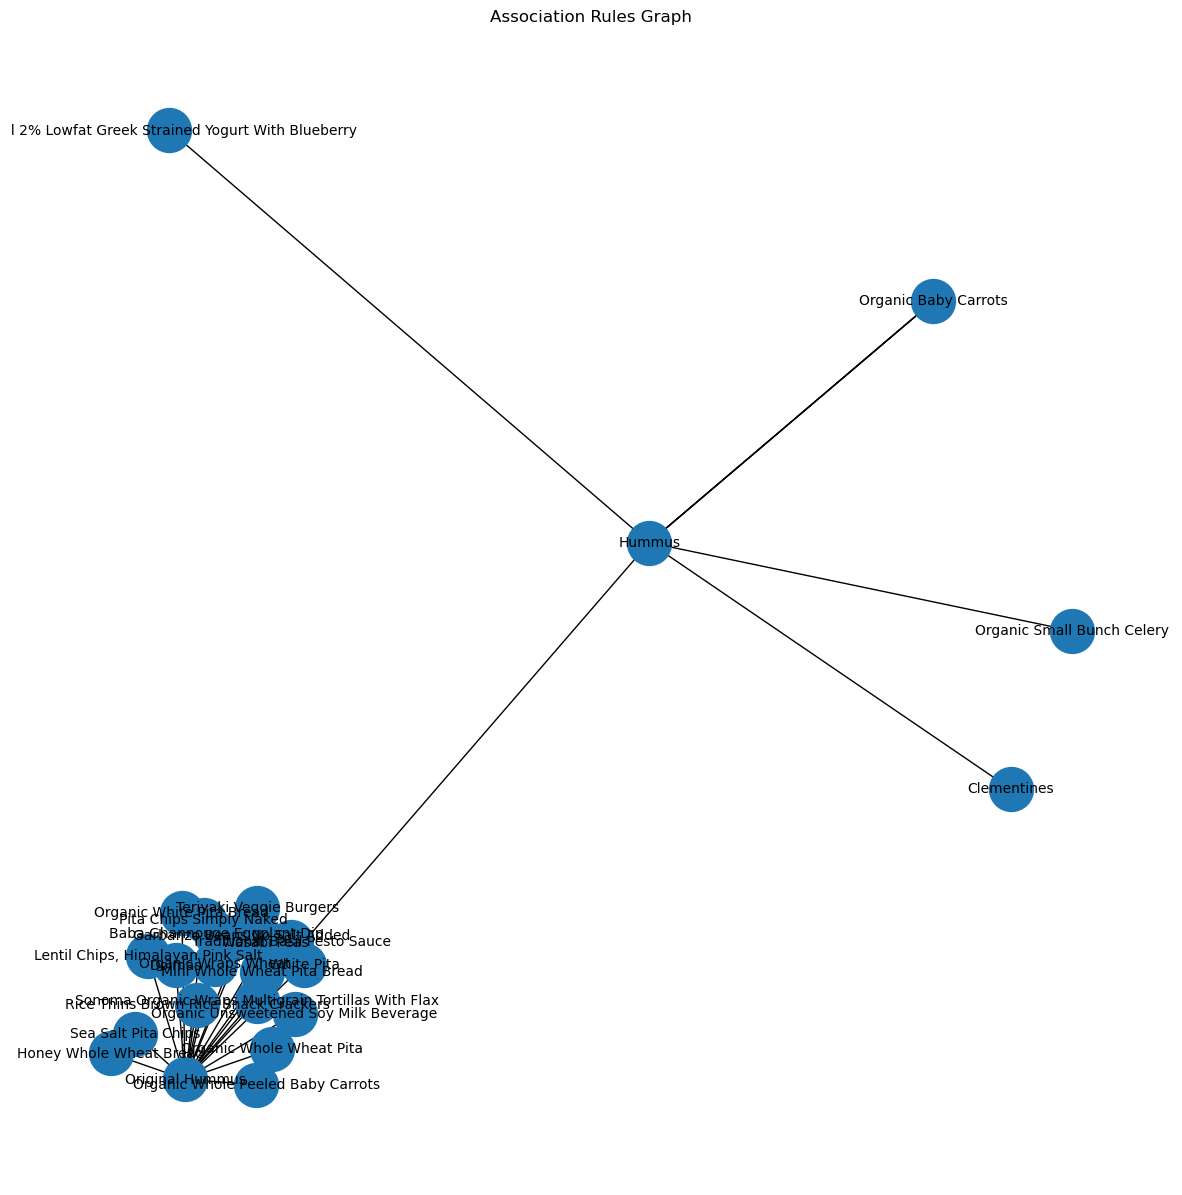

In [102]:
# Define graph_rules_subset, add the graph’s edges, and plot it. You may need a large figure size, smaller node size, and smaller font size.

graph_rules_subset = nx.MultiDiGraph()
graph_rules_subset.add_edges_from(
    df_rules_subset[['antecedent_item', 'consequent_item', 'lift']].values
)

# Then render the graph. Assume we already imported the necessary libraries.
mpl.rcParams['figure.figsize'] = [15.0, 15.0]

# Define node size based on lift values or set a constant size
node_size = 1000  # You can change this value as needed

# Define positions for all nodes using spring layout
pos = nx.spring_layout(graph_rules_subset)

# Draw the graph
nx.draw_networkx_edges(graph_rules_subset, pos, arrows=True)
nx.draw_networkx_nodes(graph_rules_subset, pos, node_size=node_size)
nx.draw_networkx_labels(graph_rules_subset, pos, font_size=10)

# Set title and display the graph
mpl.pyplot.title('Association Rules Graph')
mpl.pyplot.axis('off')  # Turn off the axis
mpl.pyplot.show()

What can you tell about people who buy hummus?

*(Write your answer here.)*

People who buy hummus are likely to also buy organic baby carrots, low-fat greek yogurt, clementines and celery. 

## Make a Prediction

Given that the basket of items contains the following items, use the full set of association rules to predict the next 20 most likely items (consequents) that the person will add to the basket in descending order of lift:

* `'Orange Bell Pepper'`
* `'Organic Red Bell Pepper'`

Hint: a single item in the basket may be a better predictor of some consequents than both items considered together. You must consider both or either, but not neither.

In [109]:
basket = {'Orange Bell Pepper', 'Organic Red Bell Pepper'}

df_rules[
    # rules where antecedent_items is basket
    df_rules['antecedent_items'].apply(lambda x: set(x) == basket)
        ] \
        .sort_values('lift', ascending=False) \
        .head(20)

,consequent_item,transaction_count,item_set_count,antecedent_count,consequent_count,antecedent_items,support,confidence,lift
364989,Organic Bell Pepper,3346083,582,2721,24331,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000174,0.213892,29.415159
370144,Yellow Bell Pepper,3346083,499,2721,26625,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000149,0.183388,23.047249
404185,Green Bell Pepper,3346083,494,2721,58005,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000148,0.181551,10.472966
603392,Organic Red Onion,3346083,278,2721,70804,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000083,0.102168,4.828310
707779,Organic Yellow Onion,3346083,366,2721,117716,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000109,0.134509,3.823435
710744,Organic Zucchini,3346083,338,2721,109412,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000101,0.124219,3.798918
800857,Limes,3346083,374,2721,146660,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000112,0.137449,3.135942
880289,Organic Hass Avocado,3346083,469,2721,220877,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000140,0.172363,2.611142
894932,Organic Strawberries,3346083,564,2721,275577,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000169,0.207277,2.516774
898628,Large Lemon,3346083,326,2721,160792,"[Orange Bell Pepper, Organic Red Bell Pepper]",0.000097,0.119809,2.493224


## Bonus: Other Interesting Findings

Find and share something else interesting about these association rules. It can be a graph, table, or some other format that illustrates your point.